In [48]:
from tensorboard.backend.event_processing import event_accumulator      
import numpy as np
import pandas as pd
from glob import glob
import sys
import tensorboard.plugins.hparams as hparams
from tensorboard.plugins.hparams import plugin_data_pb2
import tqdm
import re
import os.path
import os

interesting_keys = ['episode_reward_mean', "episode_len_mean", 'episodes_total', 'custom_metrics/inv', "time_this_iter_s", 'custom_metrics/accept']
hist_keys = ["inv", "accept"]


def create_df(inpath):
    sg = {event_accumulator.COMPRESSED_HISTOGRAMS: 1,
          event_accumulator.IMAGES: 1,
          event_accumulator.AUDIO: 1,
          event_accumulator.SCALARS: 0,
          event_accumulator.HISTOGRAMS: 0}
    ea = event_accumulator.EventAccumulator(inpath, size_guidance=sg)
    ea.Reload()
    scalar_tags = ea.Tags()['scalars']
    df = pd.DataFrame()
    events = ea.Scalars("ray/tune/episode_reward_mean")
    ids = [x.step for x in events]
    ids_s = set(x.step for x in events)
    df['step'] = ids
    walltimes = [x.wall_time for x in events]
    df['walltime'] = walltimes
    df['totalwalltime'] = walltimes[-1] - walltimes[0]
    df.set_index('step', inplace=True)
    for tag in hist_keys:
        fulltag = 'ray/tune/hist_stats/' + tag
        events = ea.Histograms(fulltag)
        indexes = [x.step for x in events if x.step in ids_s]
        mins = [x.histogram_value.min
                for x in events if x.step in ids_s]
        maxs = [x.histogram_value.max 
                for x in events if x.step in ids_s]
        means = [x.histogram_value.sum / x.histogram_value.num 
                 for x in events if x.step in ids_s]
        variances = [np.max((0, x.histogram_value.sum_squares / x.histogram_value.num - (x.histogram_value.sum / x.histogram_value.num)**2))
                     for x, mean in zip(events, means) if x.step in ids_s]
        stds = np.sqrt(variances)
        #print(events[-1].histogram_value)
        df.loc[indexes, tag+"_max"] = maxs
        df.loc[indexes, tag+"_min"] = mins
        df.loc[indexes, tag+"_mean"] = means
        df.loc[indexes, tag+"_std"] = stds
    for tag in interesting_keys:
        fultag = 'ray/tune/' + tag
        success = False
        for i in range(3):
            try:
                events = ea.Scalars(fultag)
            except KeyError:
                fultag+= "_mean"
            else:
                success = True
                break
        if not success:
            raise KeyError(fultag)

        scalars = np.array([x.value for x in events if x.step in ids_s])
        indexes = np.array([x.step for x in events if x.step in ids_s])
        df.loc[indexes, tag] = scalars

    df.reset_index(inplace=True)
    return df


def removeprefix(self: str, prefix: str, /) -> str:
    if self.startswith(prefix):
        return self[len(prefix):]
    else:
        return self[:]

In [49]:
figdir = "figures/allfig/"
print(figdir)
os.makedirs(figdir, exist_ok=True)

figures/allfig/


In [50]:
paths = {"PPO-MLP": "logs/paperrun2/e200000/ppobiglr/",
        "CMA-ES": "logs/paperrun2/e200000/cmafixed/",
        "PPO-DEEP": "logs/paperrun3/bignetfastredo/"}
alg_order = ["CMA-ES", "PPO-DEEP", "PPO-MLP"]
df = {}

for name, path in paths.items():
    df[name] = pd.read_pickle(path + "/sumup.df.pkl")
    df[name]["Algorithm"] = name

In [51]:
alldf = pd.concat(df.values())
nepisodes = 200000

In [58]:
binsize = nepisodes//200
stepbin = alldf["step"].max() // 300
print(binsize)
print(stepbin)

if "true_episode_reward_mean" not in alldf.columns:
    alldf["true_episode_reward_mean"] = alldf["episode_reward_mean"]
    alldf.loc[alldf["Algorithm"].contains("PPO"), "episode_reward_mean"] = alldf["true_episode_reward_mean"] / 2
if "p" not in alldf.columns:
    alldf["p"] = alldf["badsiteprob"]
    
    


alldf["episode_bin_right"] = alldf["episodes_total"].apply(lambda x: (x // binsize + 1) * binsize )
alldf["episode_bin_right"].where(alldf["episode_bin_right"] <= nepisodes, nepisodes, inplace=True)
alldf["step_bin_right"] = alldf["step"].apply(lambda x: (x // binsize + 1) * binsize )


1000
494417


In [59]:
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set()
sns.set_palette('colorblind')
sns.set_context('paper', font_scale=0.75)
sns.set_style("whitegrid")
figwidth=3.3
figsize=(figwidth, figwidth/1.5)

def figheight(figwidth, figaspect):
    return figwidth / figaspect

In [60]:
from pandas.api.types import CategoricalDtype
ps = [1, 0.5, 0.2, 0.1]
step = False
epcollapsed = alldf.groupby(["p", "Algorithm", "run", "episode_bin_right"], as_index=False).mean()
epcollapsed["epthousands"] = epcollapsed["episode_bin_right"] / 1000
print("ep done")
if step:
    stepcollapsed = alldf[["p", "run", "step_bin_right", "inv_mean", "inv_std", "accept_mean"]].groupby(["p", "run", "step_bin_right"], as_index=False).mean()
    stepcollapsed["p"] = stepcollapsed["p"].astype(pcat)

print("step done")
pcat = CategoricalDtype(ps, ordered=True)
epcollapsed["p"] = epcollapsed["p"].astype(pcat)
print("p as cat done")
alldf["p"] = alldf["p"].astype(pcat)

ep done
step done
p as cat done


figures/allfig/


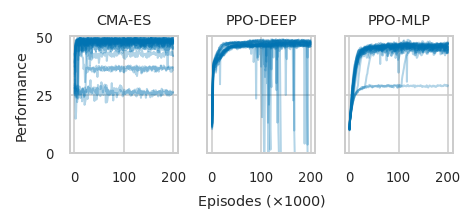

In [39]:
g = sns.FacetGrid(data=epcollapsed.query("p == 1.0"), col="Algorithm", height=figheight(figwidth/3, 0.7), aspect=0.7, despine=False, col_order=alg_order,
                 margin_titles=True, sharey=True)
g.map_dataframe(sns.lineplot, x="epthousands", y='episode_reward_mean',
        estimator=None, alpha=0.3, linewidth=1, units="run")
#g.map_dataframe(sns.lineplot, x="episode_bin_right", y='episode_reward_mean')
g.set_axis_labels("Episodes ($\\times1000$)", "Performance")

for i, ax in enumerate(g.axes.flat):
    #ax.ticklabel_format(axis="x", scilimits=(3, 3))
    if i == 1:
        ax.set_xlabel("Episodes ($\\times 1000$)")
    else:
        ax.set_xlabel("")
    ax.set_yticks([i for i in range(0, 51, 25)])
    ax.set_ylim(0, 50)
    #ax.set_xlim(0, 75)
    ax.set_xticks([i for i in range(0, 201, 100)])
g.set_titles(col_template="{col_name}")
g.tight_layout()
g.savefig(figdir + "reward_mean_detail_p1.pdf")
print(figdir)

figures/allfig/


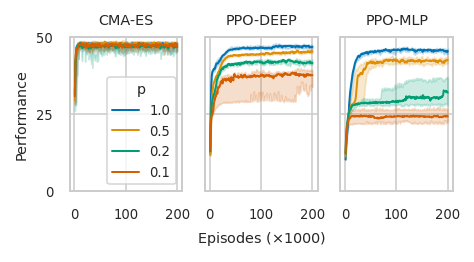

In [73]:
g = sns.FacetGrid(data=epcollapsed, hue="p", col="Algorithm", height=figheight(figwidth/3, 0.6), aspect=0.6, despine=False,
                  col_order=alg_order,
                 margin_titles=True, sharey=True)
g.map_dataframe(sns.lineplot, x="epthousands", y='episode_reward_mean',
        linewidth=1, estimator=np.median)
g.set_axis_labels("Episodes ($\\times1000$)", "Performance")


for i, ax in enumerate(g.axes.flat):
    #ax.ticklabel_format(axis="x", scilimits=(3, 3))
    if i == 0:
        ax.legend(loc="lower right", title="p")
    if i == 1:
        ax.set_xlabel("Episodes ($\\times 1000$)")
    else:
        ax.set_xlabel("")
    ax.set_yticks([i for i in range(0, 51, 25)])
    ax.set_ylim(0, 50)
    #ax.set_xlim(0, 75)
    ax.set_xticks([i for i in range(0, 201, 100)])
g.set_titles(col_template="{col_name}")
g.tight_layout()
g.savefig(figdir + "reward_mean.pdf")
print(figdir)

figures/allfig/


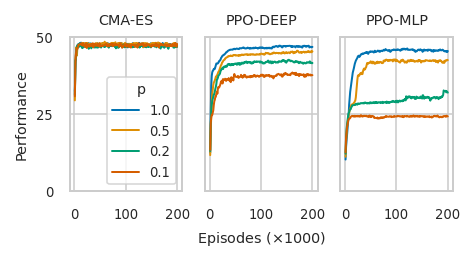

In [71]:
g = sns.FacetGrid(data=epcollapsed, hue="p", col="Algorithm", height=figheight(figwidth/3, 0.6), aspect=0.6, despine=False,
                  col_order=alg_order,
                 margin_titles=True, sharey=True, legend_out=False)
g.map_dataframe(sns.lineplot, x="epthousands", y='episode_reward_mean',
        linewidth=1, estimator=np.median, ci=None)
g.set_axis_labels("Episodes ($\\times1000$)", "Performance")

for i, ax in enumerate(g.axes.flat):
    #ax.ticklabel_format(axis="x", scilimits=(3, 3))
    if i == 0:
        ax.legend(loc="lower right", title="p")
    if i == 1:
        ax.set_xlabel("Episodes ($\\times 1000$)")
    else:
        ax.set_xlabel("")
    ax.set_yticks([i for i in range(0, 51, 25)])
    ax.set_ylim(0, 50)
    #ax.set_xlim(0, 75)
    ax.set_xticks([i for i in range(0, 201, 100)])
g.set_titles(col_template="{col_name}")
g.tight_layout()
g.savefig(figdir + "reward_mean_no_ci.pdf")
print(figdir)

figures/allfig/


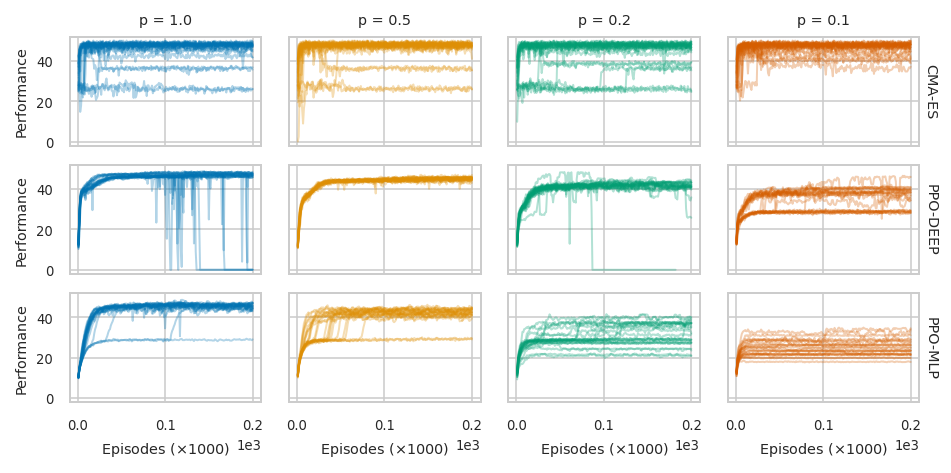

In [41]:
g = sns.FacetGrid(data=epcollapsed, row="Algorithm", col="p", hue="p", height=figheight(figwidth/2, 1.5), aspect=1.5, despine=False, row_order=alg_order,
                 margin_titles=True, sharey=True, legend_out=True)
g.map_dataframe(sns.lineplot, x="epthousands", y='episode_reward_mean',
        linewidth=1, estimator=None, units="run", alpha=0.3)
#g.map_dataframe(sns.lineplot, x="episode_bin_right", y='episode_reward_mean')
for ax in g.axes.flat:
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
    #ax.set_yticks([i for i in range(0, 51, 10)])
    ax.set_ylim(-2, 52)
g.set_axis_labels("Episodes ($\\times 1000$)", "Performance")
g.set_titles(row_template="{row_name}")
#g.add_legend()
g.tight_layout()
g.savefig(figdir + "reward_mean_full.pdf")
print(figdir)

In [62]:
epcollapsed.query("episode_bin_right == 200000").groupby("p")["episode_reward_mean"].nunique()

p
1.0    65
0.5    68
0.2    68
0.1    70
Name: episode_reward_mean, dtype: int64

In [61]:
epcollapsed.query("Algorithm == 'PPO-DEEP' and episode_bin_right == 200000").groupby("p").nunique()

,Algorithm,run,episode_bin_right,step,walltime,totalwalltime,inv_max,inv_min,inv_mean,inv_std,...,episode_reward_mean,episode_len_mean,episodes_total,custom_metrics/inv,time_this_iter_s,custom_metrics/accept,badsiteprob,true_episode_reward_mean,step_bin_right,epthousands
p,,,,,,,,,,,,,,,,,,,,,
1.0,1,96,1,23,24,24,24,24,24,24,...,21,21,23,24,24,19,1,21,23,1
0.5,1,96,1,22,24,24,24,24,24,24,...,24,24,24,24,24,24,1,24,22,1
0.2,1,96,1,21,23,23,23,23,23,23,...,23,23,23,23,23,23,3,23,21,1
0.1,1,96,1,24,24,24,24,24,24,24,...,24,24,24,24,24,24,4,24,24,1
